# Project 9 - Audrey Zhou


In [30]:
import matplotlib.pyplot as plt
from numpy import*
import numpy as np
import pandas as pd
from scipy.optimize import newton
from scipy.stats import * 
set_printoptions(threshold=float('inf'), linewidth= 200, suppress = True)
pd.set_option('display.float_format', lambda x: '%.5f' % x)

## Problem Statement

In [31]:
def CIR(r0, sd, k, r_mean, total_years, paths):
    random.seed(7)
    dt = 1/120
    steps = int(total_years/dt)
    rt = np.zeros((paths, steps + 1))
    rt[:, 0] = r0
    
    # use full truncation method for every interest rate that drops below 0
    for i in range(1, steps):
        rt[:,i] = (maximum(rt[:,i-1], 0) + k*(r_mean - maximum(rt[:,i-1], 0)) *dt 
                    + sd* sqrt(maximum(rt[:,i-1], 0))* sqrt(dt)*random.normal(0, 1, paths))
    return rt

In [32]:
def Zero10Yr(rt, r_mean, sd, k, T, t):
    
    h1 = sqrt(k**2 + 2*sd**2)
    h2 = (k + h1)/2
    h3 = (2*k*r_mean)/sd**2
    
    A = ((h1 * exp(h2*(T - t)))/(h2 * (exp(h1*(T - t)) - 1) + h1))**h3
    B = (exp(h1*(T - t)) - 1)/(h2 * (exp(h1*(T - t)) - 1) + h1)
    
    return A*exp(-B*rt)

In [33]:
def spotRate_10yr(r0, sd, k, r_mean, total_years, paths):
   
    ru = CIR(r0, sd, k, r_mean, total_years, paths)
    zeros10yr = array(list(map(lambda rt: Zero10Yr(rt, r_mean, sd, k, 10, 0), ru)))
    spot_rate = -1/10*log(zeros10yr)
    
    # choose time index that corresponds to the monthly payment
    pay_time = arange(1, total_years*12 + 1) * 10 - 1

    return spot_rate[:, pay_time]

In [34]:
def discount_factor(r0, sd, k, r_mean, total_years, paths):
    dt = 1/120
    ru = CIR(r0, sd, k, r_mean, total_years, paths)
    df = exp(-cumsum(ru*dt , axis = 1))
    # choose time index that corresponds to the monthly payment
    pay_time = arange(1, total_years*12 + 1) * 10 - 1
    
    return df[:, pay_time]

In [35]:
def cash_flow_t(t, total_years, PV_previous, r, N, CPRt):
    
    # Find schedule total payment
    MPt = (PV_previous*r)/(1 - (1 + r)**(-N + (t - 1)))
    
    # find schedule principal payment, SPPt
    SPPt = PV_previous*r*(1/(1 - (1 + r)**(-N + (t - 1))) -  1)
    
    # find prepayment amount, PPt
    PPt = (PV_previous - SPPt)*(1 - (1 - CPRt)**(1/12))
    
    # find cash flow at time t
    ct = MPt + PPt
    return ct

In [36]:
def total_principal_pay_t(t, PV_previous, r, N, CPRt):
    
    # find schedule principal payment, SPPt
    SPPt = PV_previous*r*(1/(1 - (1 + r)**(-N + (t - 1))) -  1)
    
    # find prepayment amount, PPt
    PPt = (PV_previous - SPPt)*(1 - (1 - CPRt)**(1/12))
    
    # find principal payment at time t
    TPPt = SPPt + PPt
    return TPPt

In [37]:
def refinanceIncentive(R, r_10):
    RI = 0.28 + 0.14*arctan(-8.57 + 430*(R - r_10))
    return RI

In [38]:
def burnoutEffect(PV_previous, PV0):
    BU = 0.3 + 0.7*(PV_previous/PV0)
    return BU

In [39]:
def seasonality(t):
    SG = minimum(1, t/30)
    return SG

In [40]:
def seasoning(month):
    SY  = [0.94,0.76,0.74,0.95,0.98,0.92,0.98,1.10,1.18,1.22,1.23,0.98]
    return SY[month]

In [43]:
def Numerix_CPRt(t, R, r_10, PV_previous, PV0):
    RIt = refinanceIncentive(R, r_10)
    BUt = burnoutEffect(PV_previous, PV0)
    SGt = seasonality(t)
    SYt = seasoning(int((t - 1)%12))
    CPRt = RIt*BUt*SGt*SYt
    return CPRt

In [44]:
def NumerixPrepayModel(PV0, total_years, WAC, r0, k, r_mean, sd):
   
    # initialize parameters
    r = WAC/12
    N = total_years*12
    paths = 10000
    PV_previous = PV0
    ct = np.zeros((paths, N))
    
    # find discount factor
    dft = discount_factor(r0, sd, k, r_mean, total_years, paths)
    
    # find 10 year spot yield
    r_10 = spotRate_10yr(r0, sd, k, r_mean, total_years, paths)
    
    for t in range(1 , N + 1):
        # find CPRt
        CPRt_Numerix = Numerix_CPRt(t, WAC, r_10[:, t - 1], PV_previous, PV0)
        
        # find cash flow at t
        ct[:, t - 1] = cash_flow_t(t, total_years, PV_previous, r, N, CPRt_Numerix)
        # find total principal payment
        TPPt = ct[:, t - 1] - PV_previous*r
        # Update next period present value, PVt
        PV_previous = PV_previous - TPPt

    mortage_value = mean(sum(dft*ct, axis = 1))
    
    return mortage_value

In [45]:
print("The price of the MBS evaluated by Numerix Model : ", NumerixPrepayModel(PV0 = 100000, total_years = 30, WAC = 0.08, 
                                r0 = 0.078, k = 0.6, r_mean = 0.08, sd = 0.12))

The price of the MBS evaluated by Numerix Model :  100763.34093355942


In [46]:
k = arange(0.3, 0.91, 0.1)
MBS_ks_Numerix = [(i, NumerixPrepayModel(PV0 = 100000, total_years = 30, WAC = 0.08, 
                                r0 = 0.078, k = i, r_mean = 0.08, sd = 0.12)) for i in k]

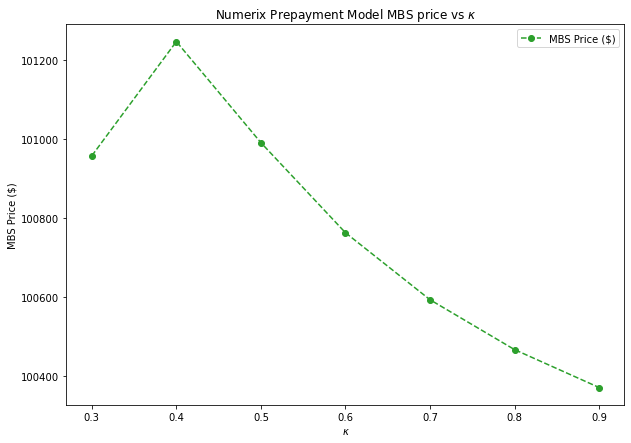

In [47]:
plt.figure(figsize=(10,7))
plt.plot(*zip(*MBS_ks_Numerix), 'C2', linestyle='--', 
         marker='o', label = 'MBS Price ($)')
plt.title("Numerix Prepayment Model MBS price vs $\kappa$")
plt.xlabel("$\kappa$")
plt.ylabel("MBS Price ($)")
plt.legend()
plt.show()

When $\kappa$ = 0.3 the short term interest rate paths are more likely to stay far away from the long run mean (slow mean reversion). Since the standard deviation of the short term rate path is 0.12, there is a moderate probability of the paths staying below 0, which triggered the full trucation conditions of the CIR model. The full truncation of the interest rate paths then led to a non-symetrical scatter around the long-run mean, which could screw the mean upwards (larger than expected). The larger mean of the short interest rate paths caused an increase of discount factors, which resulted in lower valuation of the MBS at $\kappa$ = 0.3

In [48]:
r_means = arange(0.03, 0.091, 0.01)
MBS_rs_Numerix = [(i, NumerixPrepayModel(PV0 = 100000, total_years = 30, WAC = 0.08, 
                                r0 = 0.078, k = 0.6, r_mean = i, sd = 0.12)) for i in r_means]

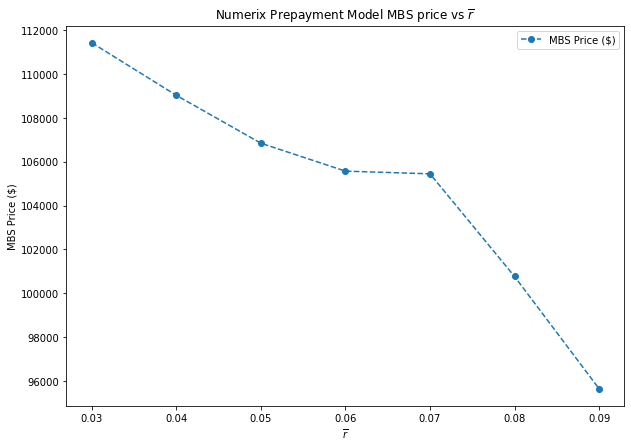

In [49]:
plt.figure(figsize=(10,7))
plt.plot(*zip(*MBS_rs_Numerix), 'C0', linestyle='--', 
         marker='o', label = 'MBS Price ($)')
plt.title("Numerix Prepayment Model MBS price vs $\overline{r}$")
plt.xlabel("$\overline{r}$")
plt.ylabel("MBS Price ($)")

plt.legend()
plt.show()

In [71]:
def discount_factor_OAS(OAS, r0, sd, k, r_mean, total_years, paths):
    dt = 1/120
    ru = CIR(r0, sd, k, r_mean, total_years, paths)
    df = exp(-cumsum((ru + OAS)*dt , axis = 1))
    
    # choose time index that corresponds to the monthly payment
    pay_time = arange(1, total_years*12 + 1) * 10 - 1
    
    return df[:, pay_time]

In [72]:
def NumerixPrepayModel_OAS(OAS, PV0, total_years, WAC, r0, k, r_mean, sd):
   
    # initialize parameters
    r = WAC/12
    N = total_years*12
    paths = 10000
    PV = np.zeros((paths, N))
    PV_previous = PV0
    ct = zeros((paths, N))
    
    # find discount factor
    dft = discount_factor_OAS(OAS, r0, sd, k, r_mean, total_years, paths)
    
    # find 10 year spot yield
    r_10 = spotRate_10yr(r0, sd, k, r_mean, total_years, paths)
     
    for t in range(1 , N + 1):
        # find CPRt
        CPRt_numerix = Numerix_CPRt(t, WAC, r_10[:, t - 1], PV_previous, PV0)
        # find cash flow at t
        ct[:, t - 1] = cash_flow_t(t, total_years, PV_previous, r, N, CPRt_numerix)
        # find total principal payment
        TPPt = ct[:, t - 1] - PV_previous*r
        # Update next period present value, PVt
        PV_previous = PV_previous - TPPt
    
    mortage_value = mean(sum(dft*ct, axis = 1))
    
    return mortage_value

In [73]:
def f_opt(OAS, market_price):
    # price difference= model price - market price
    price_difference = NumerixPrepayModel_OAS(OAS = OAS, 
                                       PV0 = 100000, total_years = 30, WAC = 0.08, 
                                       r0 = 0.078, k = 0.6, r_mean = 0.08, sd = 0.12) - market_price
    return price_difference

In [74]:
def find_OAS(market_price):
    # using Newton's method to find the OAS by finding the zero of the optimizing function
    OAS = newton(f_opt, 0, args = (market_price,), maxiter=100, tol=1e-50)
    return OAS

In [75]:
OAS_Numerix = find_OAS(market_price = 102000)
print("The option adjusted spread for Numerix Model : ", round(OAS_Numerix, 5))

The option adjusted spread for Numerix Model :  -0.0018


In [76]:
def pertubPrice(OAS):

    # pertub OAS to respective prices
    dx = 5*(0.01/100)
    # P+, P-, P0
    P_up = NumerixPrepayModel_OAS(OAS = OAS + dx, 
                                       PV0 = 100000, total_years = 30, WAC = 0.08, 
                                       r0 = 0.078, k = 0.6, r_mean = 0.08, sd = 0.12)
    P_down = NumerixPrepayModel_OAS(OAS = OAS - dx, 
                                       PV0 = 100000, total_years = 30, WAC = 0.08, 
                                       r0 = 0.078, k = 0.6, r_mean = 0.08, sd = 0.12)
    P0 = NumerixPrepayModel_OAS(OAS = OAS, 
                                       PV0 = 100000, total_years = 30, WAC = 0.08, 
                                       r0 = 0.078, k = 0.6, r_mean = 0.08, sd = 0.12)
    return [P0, P_up, P_down]

In [77]:
def OAS_duration(P_up, P_down, P0):
    dx = 5*(0.01/100)
    duration = (P_down - P_up)/(2*dx*P0)
    
    return duration

In [78]:
def OAS_convexity(P_up, P_down, P0):
    dx = 5*(0.01/100)
    convexity = (P_down + P_up - 2*P0)/(2 * (dx)**2 * P0)
    
    return convexity

In [79]:
P0, P_up, P_down = pertubPrice(OAS_Numerix)
durationOAS = OAS_duration(P_up, P_down, P0)
convexityOAS = OAS_convexity(P_up, P_down, P0)

In [80]:
print("The duration of option adjusted spread for Numerix Model : ", durationOAS)
print("The conexity of option adjusted spread for Numerix Model : ", convexityOAS)

The duration of option adjusted spread for Numerix Model :  6.809457006579489
The conexity of option adjusted spread for Numerix Model :  41.252103033840804


In [81]:
def Numerix_IO_PO(PV0, total_years, WAC, r0, k, r_mean, sd):
   
    # initialize parameters
    r = WAC/12
    N = total_years*12
    paths = 10000
    PV_previous = array([PV0]*paths)
    ct = np.zeros((paths, N))
    
    # Initialize PO, IO portion of the MBS
    Interest = zeros((paths, N))
    Principal = zeros((paths, N))
    
    # find discount factor
    dft = discount_factor(r0, sd, k, r_mean, total_years, paths)
    
    # find 10 year spot yield
    r_10 = spotRate_10yr(r0, sd, k, r_mean, total_years, paths)
     
    for t in range(1 , N + 1):
        # find CPRt
        CPRt_Numerix = Numerix_CPRt(t, WAC, r_10[:, t - 1], PV_previous, PV0)
        # find cash flow at t
        ct[:, t - 1] = cash_flow_t(t, total_years, PV_previous, r, N, CPRt_Numerix)
        # find total principal payment
        Interest[:, t - 1] = PV_previous*r
        TPPt = ct[:, t - 1] - PV_previous*r
        Principal[:, t - 1] =  TPPt
        # Update next period present value, PVt
        PV_previous = PV_previous - TPPt

   
    IO = mean(sum(dft*Interest, axis = 1))
    PO = mean(sum(dft*Principal, axis = 1))
    
    return [IO, PO]

In [82]:
r_means = arange(0.03, 0.091, 0.01)
IO = [(i, Numerix_IO_PO(PV0 = 100000, total_years = 30, WAC = 0.08, 
                                r0 = 0.078, k = 0.6, r_mean = i, sd = 0.12)[0]) for i in r_means]
pd.DataFrame(IO, columns=['long run mean (r)',  'Interest Only Price($)'])

,long run mean (r),Interest Only Price($)
0,0.03000,27208.53551
1,0.04000,26837.11926
2,0.05000,27201.25987
3,0.06000,33711.41875
4,0.07000,51131.33774
5,0.08000,53631.82606
6,0.09000,52449.65583


Find PO portion of the MBS

In [83]:
PO = [(i, Numerix_IO_PO(PV0 = 100000, total_years = 30, WAC = 0.08, 
                                r0 = 0.078, k = 0.6, r_mean = i, sd = 0.12)[1]) for i in r_means]
pd.DataFrame(PO, columns=['long run mean (r)',  'Principal Only Price($)'])

,long run mean (r),Principal Only Price($)
0,0.03000,84220.02753
1,0.04000,82192.99875
2,0.05000,79643.83463
3,0.06000,71860.32871
4,0.07000,54316.91533
5,0.08000,47131.51487
6,0.09000,43190.45736


Plot IO, PO portion vs. $\bar{r}$

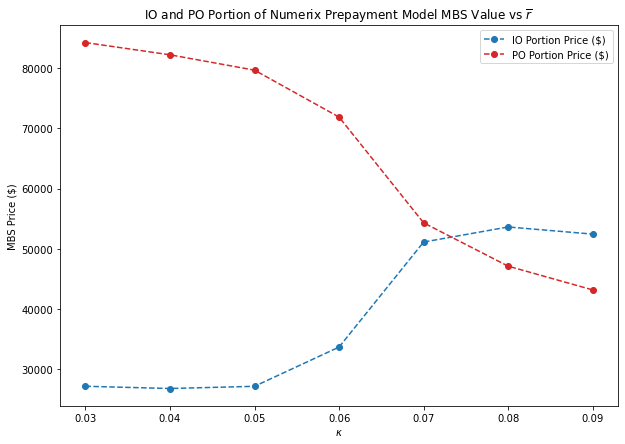

In [84]:
plt.figure(figsize=(10,7))
plt.plot(*zip(*IO), 'C0', linestyle='--', 
         marker='o', label = 'IO Portion Price ($)')
plt.plot(*zip(*PO), 'C3', linestyle='--', 
         marker='o', label = 'PO Portion Price ($)')

plt.title("IO and PO Portion of Numerix Prepayment Model MBS Value vs $\overline{r}$")
plt.xlabel("$\kappa$")
plt.ylabel("MBS Price ($)")
plt.legend()
plt.show()